## Предсказание объемов продаж на ограниченом объеме

In [1]:
%pylab inline
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics
from sklearn import grid_search
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import SGDRegressor

import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import auc, mean_squared_error, log_loss, roc_auc_score, zero_one_loss, accuracy_score, precision_score, recall_score

from hyperopt import hp, tpe, STATUS_OK, Trials, rand
from hyperopt import fmin as fminHyper

import MySQLdb

from math import ceil

from datetime import timedelta
import datetime

from sklearn.model_selection import TimeSeriesSplit

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**Загрузка данных**

In [193]:
data = pd.read_csv('../data/prepared_data.csv', sep=';')
wdata = pd.read_csv('../data/4y_prepared_data.csv', sep=';')
data

**Временные ряды**

In [ ]:
series = pd.DataFrame(data.groupby(['DptDt'])['resHoldTotal'].sum()).add_suffix('Sum').reset_index()
series.sort_values(['DptDt'], inplace = True)
series

In [ ]:
x = np.arange(0, len(series))
plt.figure(figsize = (20, 15))
plt.plot(series.DptDt, series.resHoldTotalSum)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["weekday"] = pd.DatetimeIndex(data.index).weekday
    data['WeekOfMonth'] = [week_of_month(x) for x in pd.DatetimeIndex(data.index)]
    data['MonthDpt'] = pd.DatetimeIndex(data.index).month 
    data['QuarterDpt'] = pd.DatetimeIndex(data.index).quarter 
    data['YearDpt'] = pd.DatetimeIndex(data.index).year
    data['is_weekend'] = data.weekday.isin([5,6])*1

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [ ]:
def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'nthread' : 4,
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees, early_stopping_rounds=50)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(20, 15))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(20, 15))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [ ]:
series.set_index('DptDt', inplace=True)
series.index.name = None
series

In [ ]:
XGB_forecast(series, test_size=0.2, lag_start=5, lag_end=100)

In [ ]:
data['resHoldTotal'] = y

**Деление данных на тренировочную и тестовую выборки**

In [133]:
test_data = data[data.YearDpt == 2017][data.MonthDpt == 3].copy()
test_y = test_data.resHoldTotal.copy()

data = data.drop(test_data.index.values).copy()
y = data.resHoldTotal.copy()

In [134]:
test_data.drop('fltNrArrDt', axis = 1, inplace = True)
test_data.drop('DptDt', axis = 1, inplace = True)
test_data.drop('resHoldTotal', axis = 1, inplace = True)

data.drop('fltNrArrDt', axis = 1, inplace = True)
data.drop('DptDt', axis = 1, inplace = True)
data.drop('resHoldTotal', axis = 1, inplace = True)

In [136]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = list()
y_test = list()


for flt in data.flightNrSf.unique():  
    data1 = data[data.flightNrSf == flt].copy()
    X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, y[data1.index], test_size = 0.1, random_state = 53)
            
    X_train = pd.concat([X_train, X_train1])
    X_test = pd.concat([X_test, X_test1])
    y_train.extend(y_train1)
    y_test.extend(y_test1)


X_train = pd.concat([X_train, X_train1])
X_test = pd.concat([X_test, X_test1])
y_train.extend(y_train1)
y_test.extend(y_test1)

# X_test = data[data.YearDpt == 2015][data.MonthDpt == 2].copy()
# y_test = y[X_test.index]

# X_train = data.drop(X_test.index).copy()
# y_train = y[X_train.index]

dtrain = xgb.DMatrix(X_train.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_train)
dvalid = xgb.DMatrix(X_test.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y_test)
dtest = xgb.DMatrix(test_data.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), test_y)

**Модель**

In [137]:
def score(params):
    print("Training with params:")
    print(params)
    
    num_round = int(params['n_estimators'])    
    del params['n_estimators']
    params['max_depth'] = (int) (params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 1))
    score = mean_squared_error(y_test, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [138]:
def optimize(trials):

    space = {
    'n_estimators' : 75,
    'eta' : hp.quniform('eta', 0.05, 0.5, 0.025),
    'max_depth' : hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
    'gamma' : 0,
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
    'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1, 0.25),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.25),
    'reg_lambda' : hp.quniform('reg_lambda', 0, 1, 0.25),
    'objective': 'reg:linear',
    'nthread' : 4,
    'silent' : 1
    }
    best = fminHyper(score, space, algo=tpe.suggest, trials=trials, max_evals=75)

    print(best)

In [139]:
%%time
trials = Trials()
optimize(trials)

Training with params:
{'colsample_bytree': 0.5, 'n_estimators': 75, 'objective': 'reg:linear', 'gamma': 0, 'nthread': 4, 'reg_lambda': 0.75, 'colsample_bylevel': 0.5, 'max_depth': 8.0, 'eta': 0.42500000000000004, 'min_child_weight': 5.0, 'silent': 1, 'reg_alpha': 0.5, 'subsample': 0.75}
	Score 56.69699795569934


Training with params:
{'colsample_bytree': 1.0, 'n_estimators': 75, 'objective': 'reg:linear', 'gamma': 0, 'nthread': 4, 'reg_lambda': 1.0, 'colsample_bylevel': 0.75, 'max_depth': 8.0, 'eta': 0.15000000000000002, 'min_child_weight': 5.0, 'silent': 1, 'reg_alpha': 0.5, 'subsample': 1.0}
	Score 47.04463364402024


Training with params:
{'colsample_bytree': 0.75, 'n_estimators': 75, 'objective': 'reg:linear', 'gamma': 0, 'nthread': 4, 'reg_lambda': 0.75, 'colsample_bylevel': 0.75, 'max_depth': 10.0, 'eta': 0.17500000000000002, 'min_child_weight': 6.0, 'silent': 1, 'reg_alpha': 1.0, 'subsample': 0.5}
	Score 41.33461778535386


Training with params:
{'colsample_bytree': 0.75, 'n_es

KeyboardInterrupt: 

In [140]:
params = {'colsample_bytree': 1.0, 'n_estimators': 75, 'objective': 'reg:linear', 'gamma': 0, 'nthread': 4, 'reg_lambda': 0.5, 'colsample_bylevel': 1.0, 'max_depth': 10, 'eta': 0.35000000000000003, 'min_child_weight': 3.0, 'silent': 1, 'reg_alpha': 0.25, 'subsample': 1.0}

## Тренировка на полных данных

In [141]:
dtrain_full = xgb.DMatrix(data.drop("FlightID", axis = 1).drop("fltNrDptDt", axis = 1), y)

In [142]:
xgbCvResult = xgb.cv(params, dtrain_full, num_boost_round=500, early_stopping_rounds=25, nfold=5, metrics=["rmse"], verbose_eval=True)

[0]	train-rmse:17.3502+0.0703522	test-rmse:17.3814+0.31723
[1]	train-rmse:13.7399+0.0504819	test-rmse:13.8051+0.257095
[2]	train-rmse:10.9095+0.334056	test-rmse:11.0465+0.131165
[3]	train-rmse:9.32769+0.386786	test-rmse:9.54269+0.351353
[4]	train-rmse:8.21581+0.146404	test-rmse:8.49152+0.13005
[5]	train-rmse:7.42747+0.139107	test-rmse:7.81186+0.168717
[6]	train-rmse:6.89659+0.0949027	test-rmse:7.35312+0.148958
[7]	train-rmse:6.56098+0.089834	test-rmse:7.06989+0.133365
[8]	train-rmse:6.34074+0.064703	test-rmse:6.90385+0.136498
[9]	train-rmse:6.18368+0.0578857	test-rmse:6.80447+0.137321
[10]	train-rmse:6.00175+0.0532173	test-rmse:6.70353+0.162094
[11]	train-rmse:5.84697+0.0468088	test-rmse:6.61206+0.140244
[12]	train-rmse:5.71192+0.0398492	test-rmse:6.52442+0.169444
[13]	train-rmse:5.59075+0.0375523	test-rmse:6.46432+0.15579
[14]	train-rmse:5.49822+0.0475117	test-rmse:6.42268+0.147374
[15]	train-rmse:5.38252+0.0429677	test-rmse:6.3593+0.15225
[16]	train-rmse:5.32485+0.0478186	test-rmse:6

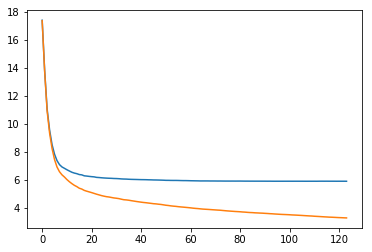

In [143]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-rmse-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-rmse-mean'])

In [144]:
best_num_round = np.argmin(xgbCvResult['test-rmse-mean'])
print(best_num_round)

123


In [145]:
bestXgb = xgb.train(params, dtrain_full, best_num_round)

In [146]:
xgboost_predict_proba = [int(x)for x in bestXgb.predict(dtest)]
for i in range(0, len(xgboost_predict_proba)):
    if xgboost_predict_proba[i] < 0:
        xgboost_predict_proba[i] = 0
        
mse = mean_squared_error(dtest.get_label(), xgboost_predict_proba)
print('Mse: {0}'.format(mse))

Mse: 48.85437782391012


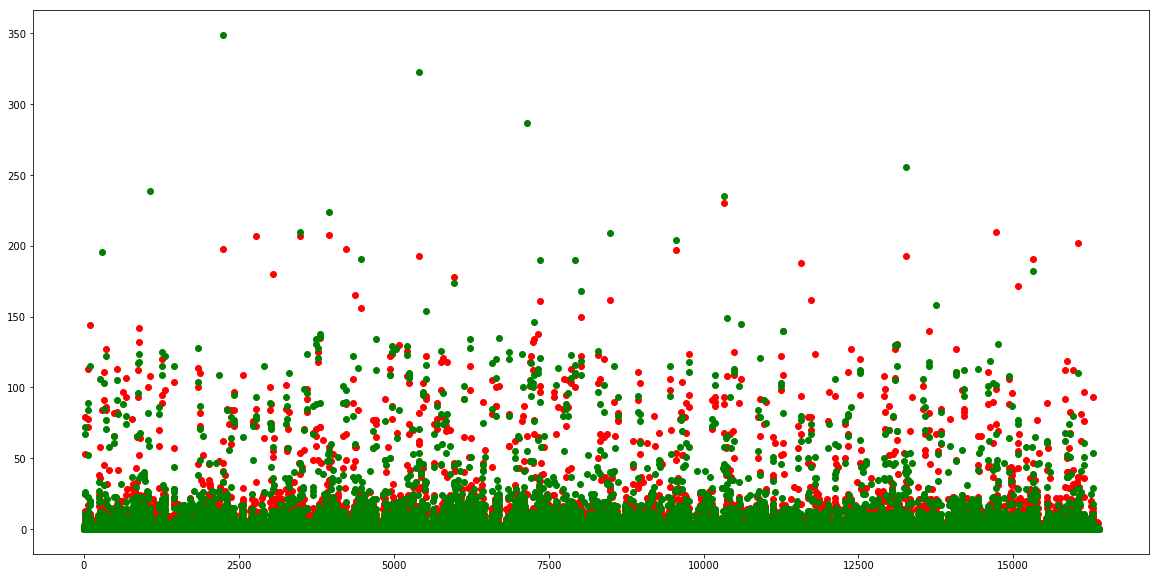

In [147]:
plt.figure(figsize=(20,10))
x = np.arange(0, len(xgboost_predict_proba))
plt.plot(x, xgboost_predict_proba, 'ro', x, dtest.get_label(), 'go')

In [148]:
res = test_data.copy()
res['actual'] = test_y.copy()
res['predictions'] = [int(x) for x in xgboost_predict_proba]
for i in range(0, len(res.predictions)):
    if res.predictions.values[i] < 0:
        res.predictions.values[i] = 0
        
res.tail(125)

,FlightID,Code,fltNrDptDt,DptTime,ArrTime,flightNrSf,segment,DayOfWeekDpt,WeekOfMonthDpt,MonthDpt,...,DayOfWeekArr,WeekOfMonthArr,MonthArr,QuarterArr,YearArr,IsWeekendArr,Holiday,IsHoliday,actual,predictions
237064,250647,2,2017-03-08,6,8,1,9,3,2,3,...,3,2,3,1,2017,0,2,0,0.0,0
237065,250647,3,2017-03-08,6,8,1,9,3,2,3,...,3,2,3,1,2017,0,2,0,0.0,0
237066,250647,4,2017-03-08,6,8,1,9,3,2,3,...,3,2,3,1,2017,0,2,0,1.0,3
237067,250711,2,2017-03-09,13,20,6,10,3,2,3,...,4,2,3,1,2017,0,2,0,5.0,5
237068,250711,3,2017-03-09,13,20,6,10,3,2,3,...,4,2,3,1,2017,0,2,0,3.0,3
237069,250711,4,2017-03-09,13,20,6,10,3,2,3,...,4,2,3,1,2017,0,2,0,5.0,16
237070,250711,5,2017-03-09,13,20,6,10,3,2,3,...,4,2,3,1,2017,0,2,0,25.0,20
237071,250711,2,2017-03-09,13,21,6,11,3,2,3,...,4,2,3,1,2017,0,2,0,0.0,1
237072,250711,3,2017-03-09,13,21,6,11,3,2,3,...,4,2,3,1,2017,0,2,0,0.0,0
237073,250711,4,2017-03-09,13,21,6,11,3,2,3,...,4,2,3,1,2017,0,2,0,2.0,5


In [149]:
res.to_excel("whole_results_" + str(mse) + ".xls")

In [150]:
# todo: refactor using groupby
res_s = pd.DataFrame(columns = ("FlightID", "Code", "Date", "FltNr", "actual", "predictions"))
count = 0
for flightID in unique(res.FlightID.values):
    for code in unique(res.Code[res.FlightID == flightID].values):
        date = res.fltNrDptDt[res.FlightID == flightID][res.Code == code].values[0]
        fltNr = res.flightNrSf[res.FlightID == flightID][res.Code == code].values[0]
        res_s.loc[count] = (flightID, code, date, fltNr, sum(res.actual[res.FlightID == flightID][res.Code == code].values), sum(res.predictions[res.FlightID == flightID][res.Code == code].values))
        count += 1

In [151]:
print('Mse: {0}'.format(mean_squared_error(res_s.actual, res_s.predictions)))
res_s.head(50)

Mse: 2026.303550973654


,FlightID,Code,Date,FltNr,actual,predictions
0,44319,0,2017-03-27,0,10.0,6
1,44319,1,2017-03-27,0,39.0,34
2,44319,2,2017-03-27,0,99.0,95
3,44319,3,2017-03-27,0,79.0,64
4,44438,2,2017-03-27,1,74.0,91
5,44438,3,2017-03-27,1,96.0,94
6,44438,4,2017-03-27,1,108.0,141
7,44576,2,2017-03-27,6,34.0,21
8,44576,3,2017-03-27,6,13.0,18
9,44576,4,2017-03-27,6,194.0,249


In [152]:
res_s.to_excel("results_" + str(mse) + ".xls")

**Общий прогзноз + год вперед**

In [237]:
# predict all data
dtrain4y = xgb.DMatrix(wdata.drop("FlightID", axis = 1)
                       .drop("fltNrDptDt", axis = 1)
                       .drop('resHoldTotal', axis = 1).drop('fltNrArrDt', axis = 1).drop('DptDt', axis = 1), 
                       wdata.resHoldTotal)
pred4y = bestXgb.predict(dtrain4y)

In [241]:
wdata['predictions'] = [int(x) for x in pred4y]
for i in range(0, len(wdata.predictions)):
    if wdata.predictions.values[i] < 0:
        wdata.predictions.values[i] = 0

In [246]:
wdata.to_csv('4ypred.csv', sep=';')

In [ ]:
wdata